# Challenge: Sentiment Analysis with Naive Bayes

In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB

%matplotlib inline

In this assignment, I am going to use a dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). Specifically, it is a sentiment analysis dataset taken from 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015. The dataset consists of four different company data files. I will use the Amazon data file for this analysis.


Plan
1. Data Exploration

    a. Load data file
    
    b. Inspect it's structure


2. Data Cleaning

    a. Clean sentences, removing punctuation and lower case. 
    
    b. Review sentences with score 1 and choose words that seem positive.
    
    c. Add columns to the DataFrame with these positive words.


3. Feature Engineering

    a. Inspect feature correlations using a correlations map.
    
    b. Remove any features that appear highly correlated.


4. Modeling

    a. Setup up a sklearn BernoulliNB model.
    
    b. Determine number of misslabeled sentences.

## Data Exploration
### Load data

In [2]:
data_file = 'amazon_cells_labelled.txt'
df = pd.read_csv(f'./data/{data_file}', delimiter='\t', header=None)
df.columns = ['sentence', 'label']

In [3]:
df.head()

,sentence,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [31]:
print(f'The fraction of positive labels is {df["label"].sum() / len(df)}.')

The fraction of positive labels is 0.5.


## Data Cleaning
Clean the sentences.
1. Remove punctuation.
2. Convert all words to lower case.
3. Remove common words.

In [5]:
punctuation = ['!', '(', ')', '/', ';', ':', ',', '?', '.']
common_words = ['the', 'and', 'i', 'is', 'it', 'a', 'this', 'to', 'my', 'for', 'with', 'of', 'on', 'have', 'was',
               'in', 'that', 'so', 'has', 'and', 'are', 'but', 'had', 'use', 'you', 'as', 'all']

In [6]:
def clean_sentences(df):
    
    dirty_sentences = df.loc[:, 'sentence'].values
    
    # Remove punctuation
    clean_sentences = dirty_sentences
    for mark in punctuation:
        clean_sentences = [x.replace(mark, '') for x in clean_sentences]
    
    # Convert words to lower case
    # Also, remove common words
    clean_list = []
    for sentence in clean_sentences:
        split_sentence = sentence.split(' ')
        clean_split_sentence = [x.strip().lower() for x in split_sentence]
        for word in common_words:
            if word in clean_split_sentence:
                clean_split_sentence.remove(word)
        clean_sentence = ' '.join(clean_split_sentence)
        clean_list.append(clean_sentence)
        
    df['clean_sentence'] = clean_list
    
    return df.copy()

In [7]:
df_clean = clean_sentences(df)

In [8]:
df_clean.head()

,sentence,label,clean_sentence
0,So there is no way for me to plug it in here i...,0,there no way me plug here in us unless go by c...
1,"Good case, Excellent value.",1,good case excellent value
2,Great for the jawbone.,1,great jawbone
3,Tied to charger for conversations lasting more...,0,tied charger conversations lasting more than 4...
4,The mic is great.,1,mic great


### Select keywords
1. Select positive sentences.
2. Join sentences into one, long list.
3. Print 20 most common words.
4. Return to data cleaning step and remove common words.
5. Once common words have been removed, select 10 of the most common positive words to use.

In [9]:
positive_list = ' '.join(df.loc[df['label'] == 1, 'clean_sentence'].values.tolist()).split(' ')

In [10]:
pd.Series(positive_list).value_counts()[:20]

great        92
phone        86
very         69
good         62
the          61
works        46
product      33
quality      31
headset      31
well         31
sound        27
excellent    26
price        25
one          23
nice         22
battery      22
best         21
recommend    20
is           20
love         20
dtype: int64

In [11]:
positive_words = ['great', 'very', 'good', 'works', 'well', 'excellent', 'nice', 'best', 'recommend', 'love']

### Add features
Add positive words as additional columns to the cleaned dataset.

In [12]:
def add_positive_words(df):
    for word in positive_words:
        df[word] = df['clean_sentence'].str.contains(f' {word} ', case=False)
    return df

In [13]:
df_clean = add_positive_words(df_clean)

In [14]:
df_clean.head()

,sentence,label,clean_sentence,great,very,good,works,well,excellent,nice,best,recommend,love
0,So there is no way for me to plug it in here i...,0,there no way me plug here in us unless go by c...,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,good case excellent value,False,False,False,False,False,True,False,False,False,False
2,Great for the jawbone.,1,great jawbone,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,tied charger conversations lasting more than 4...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,mic great,False,False,False,False,False,False,False,False,False,False


## Feature Engineering
### Feature correlations
Inspect the correlations between the postive word features.

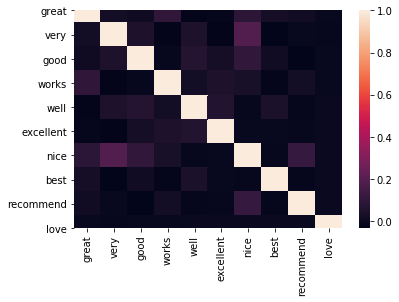

In [15]:
sns.heatmap(df_clean.loc[:, positive_words].corr())
plt.show()

**Observation:** Great! None of the features appear to be correlated.

## Modeling

In [16]:
# Define feature and target variables
X = df_clean.loc[:, positive_words]
y = df_clean['label']

In [17]:
# Instantiate the model
bnb = BernoulliNB()

# Fit model to the features
bnb.fit(X, y)

# Predict the targets using the fitted model
y_pred = bnb.predict(X)

# Find and print model accuracy
correct_predictions = (y == y_pred).sum()
total = X.shape[0]
accuracy = (correct_predictions / total) * 100
print(f'The model accuracy is {accuracy:0.1f}%.')

The model accuracy is 62.6%.


## Comparing with other datasets
### Yelp

In [18]:
data_file = 'yelp_labelled.txt'
df_yelp = pd.read_csv(f'./data/{data_file}', delimiter='\t', header=None)
df_yelp.columns = ['sentence', 'label']

In [20]:
df_yelp_clean = clean_sentences(df_yelp)

In [21]:
df_yelp_clean = add_positive_words(df_yelp_clean)

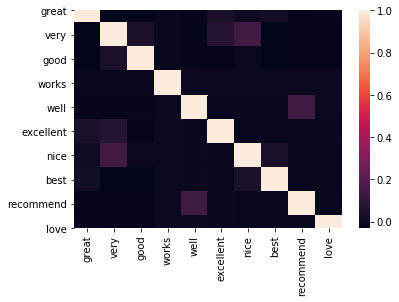

In [22]:
sns.heatmap(df_yelp_clean.loc[:, positive_words].corr())
plt.show()

In [23]:
# Define feature and target variables
X_yelp = df_yelp_clean.loc[:, positive_words]
y_yelp = df_yelp_clean['label']

In [24]:
# Predict the targets using the fitted model
y_pred = bnb.predict(X_yelp)

# Find and print model accuracy
correct_predictions = (y_yelp == y_pred).sum()
total = X_yelp.shape[0]
accuracy = (correct_predictions / total) * 100
print(f'The model accuracy is {accuracy:0.1f}%.')

The model accuracy is 60.7%.


### IMDB

In [25]:
data_file = 'imdb_labelled.txt'
df_imdb = pd.read_csv(f'./data/{data_file}', delimiter='\t', header=None)
df_imdb.columns = ['sentence', 'label']

In [26]:
df_imdb_clean = clean_sentences(df_imdb)

In [27]:
df_imdb_clean = add_positive_words(df_imdb_clean)

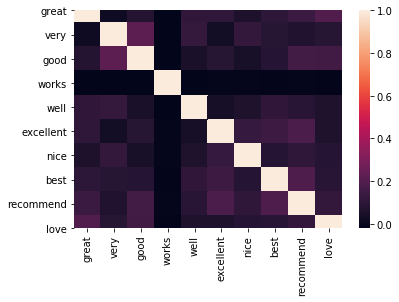

In [28]:
sns.heatmap(df_imdb_clean.loc[:, positive_words].corr())
plt.show()

In [29]:
# Define feature and target variables
X_imdb = df_imdb_clean.loc[:, positive_words]
y_imdb = df_imdb_clean['label']

In [30]:
# Predict the targets using the fitted model
y_pred = bnb.predict(X_imdb)

# Find and print model accuracy
correct_predictions = (y_imdb == y_pred).sum()
total = X_imdb.shape[0]
accuracy = (correct_predictions / total) * 100
print(f'The model accuracy is {accuracy:0.1f}%.')

The model accuracy is 57.0%.


**Observations:**
The model prediction for the Amazon dataset is quite low, 62.6%. The model fits to the additional datasets are also low, 57% and 60.7%